In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
from ast import literal_eval
import json
# import plotly.express as px
from ast import literal_eval
from imdb import IMDb

# modeling
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [20, 8]


In [3]:
train = pd.read_csv('../data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
test = pd.read_csv('../data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

#### Thoughts on variables:
- A big **budget** does not necessarily leads to a big revenue, money needs to be spent on the right places.
- a **language** might not influence the revenue, but the **number of spoken languages** might do. (check if the number of spoken languages influences the revenue)
- **popularity** is a floating varible; it does not seem to influence the revenue so I decided to drop it
- **Crew** is definitely an very important factor in predicting the box office. I can import some external data to measure the influence of an individual actor/producer, like the number of followers on Twitter.
- Does **ratings** of the movies influence revenues?


### Thoughts about external datasets:
- Box offices of movies increasingly rely on their performance in foreign markets; is it possible to integrate the information of foreign market distribution?
- Missing budget/revenue data, it can be recovered(scrapped from imdbpro)
- 

In [5]:
# Hyperparameters:
val_set_ratio = 0.2

## Basic Data Cleaning


In [6]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [7]:
test['revenue'] = 0
train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test])

In [8]:
combined['imdb_id'] = combined['imdb_id'].astype('str')
    
#runtime: look for missing runtimes in the imdb dataset; fill the rest with mean
ia = IMDb()
missing_runtime_df = combined[(combined['runtime'] == 0) | (combined['runtime'].isna())]
for movie_id in missing_runtime_df['imdb_id']:
    movie = ia.get_movie(movie_id[2:])
    imdb_runtime = movie.get('runtimes')
    if imdb_runtime is not None:
        combined.loc[combined['imdb_id'] == movie_id, 'runtime'] = float(imdb_runtime[0])
# fill the rest with mean
missing_runtime_df = combined[(combined['runtime'] == 0) | (combined['runtime'].isna())]
for movie_id in missing_runtime_df['imdb_id']:
    combined.loc[combined['imdb_id'] == movie_id, 'runtime'] = combined['runtime'].mean()

# convert crew/cast to list of dicts
combined.loc[pd.notna(combined['crew']), 'crew'] = combined[pd.notna(combined['crew'])]['crew'].apply(literal_eval)
combined.loc[pd.notna(combined['cast']), 'cast'] = combined[pd.notna(combined['cast'])]['cast'].apply(literal_eval)

In [9]:
train = combined[combined['is_train'] == 1]
test = combined[combined['is_train'] == 0]
combined.shape[0]

7398

## EDA

### Numerical Variables:

In [9]:
train[['budget', 'runtime', 'revenue']].corr()

,budget,runtime,revenue
budget,1.000000,0.240605,0.752965
runtime,0.240605,1.000000,0.220226
revenue,0.752965,0.220226,1.000000


We can see that the correlation between revenue and budget is most obvious.

#### Budget:

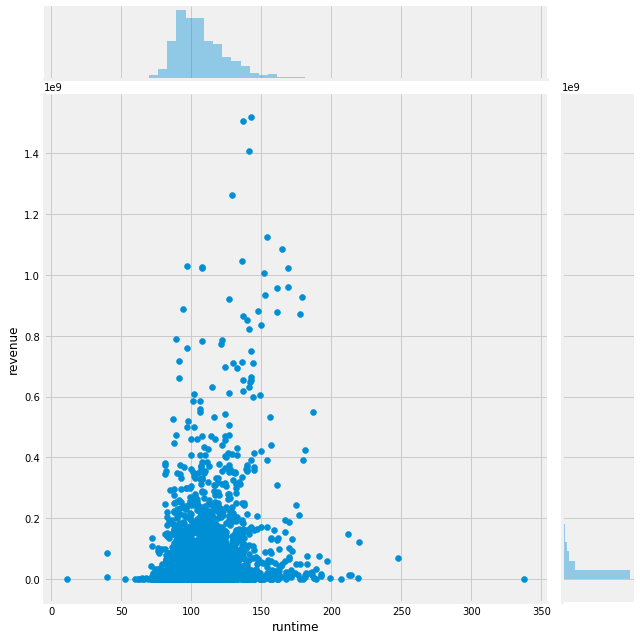

In [10]:
sns.jointplot(x=train['runtime'], y=train['revenue'], height=9, ratio=6)

### Date_released:
I found date_released to be an really interesting variable. It can be a lens by which we can discover the trends and patterns of the movie market. Before digging into the dataset, I have these questions in mind:
- How do revenues fluctuate along these years?
- How do revenues fluctuate between different months of each year? 
- Do lengths of films change?  

In [10]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
combined[['release_month','release_day','release_year']]=combined['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
combined.loc[ (combined['release_year'] <= 19) & (combined['release_year'] < 100), "release_year"] += 2000
combined.loc[ (combined['release_year'] > 19)  & (combined['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(combined['release_date']) 
combined['release_dayofweek'] = releaseDate.dt.dayofweek
combined['release_quarter'] = releaseDate.dt.quarter

train = combined[combined['is_train'] == 1]
test = combined[combined['is_train'] == 0]


**A General View:**

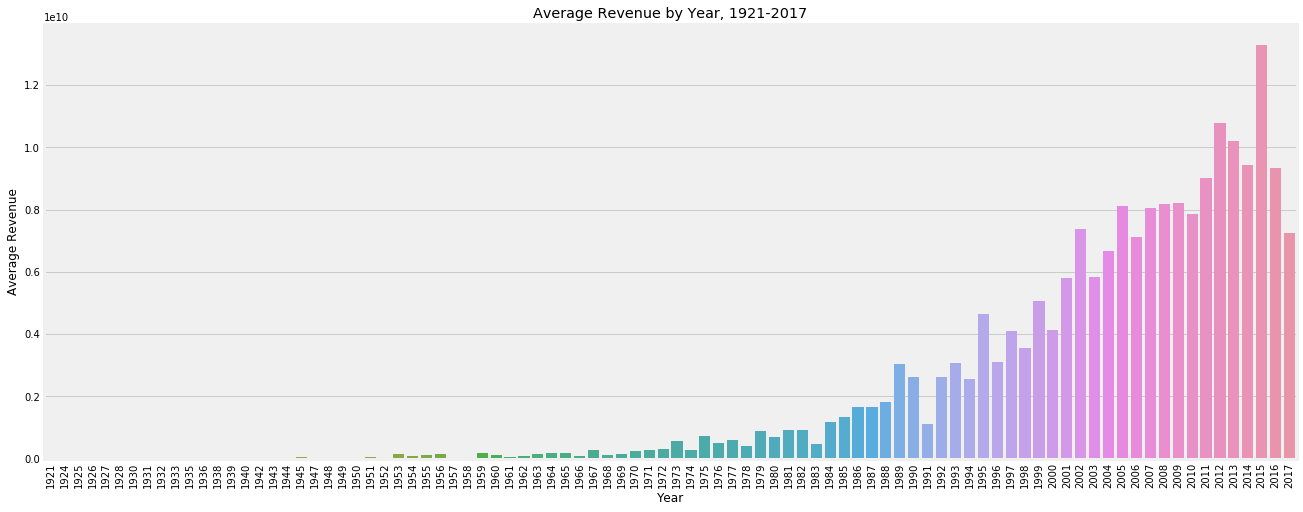

In [12]:
plt.rcParams['figure.figsize'] = [20, 8]

avg_rev_by_year = train.groupby('release_year')['revenue'].sum()
avg_rev_by_year_plot = sns.barplot(x=avg_rev_by_year.index, y=avg_rev_by_year.values)
avg_rev_by_year_plot.set_xticklabels(labels=avg_rev_by_year.index, rotation=90)
avg_rev_by_year_plot.set(xlabel='Year', ylabel='Average Revenue', title='Average Revenue by Year, 1921-2017')
plt.show()

**We can see that there can be huge difference between average revenues between the years. Interestingly, if you take a look at the history of Hollywood,(TODO)**

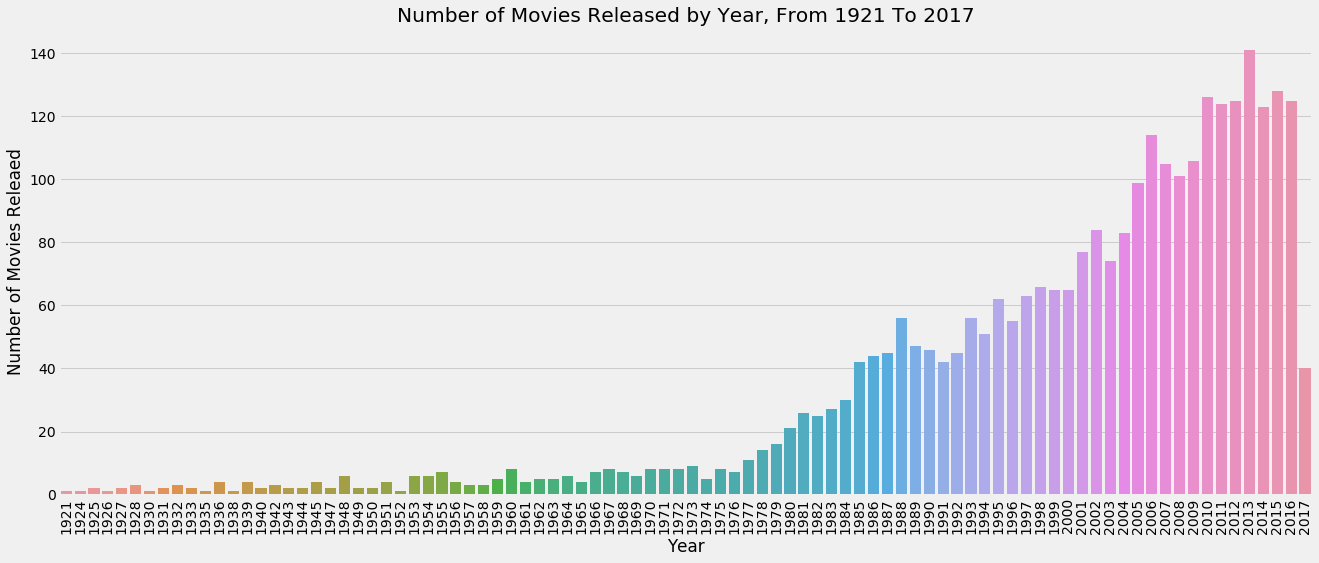

In [15]:
num_by_year = train.groupby('release_year')['imdb_id'].count()
num_by_year_plot = sns.barplot(x=num_by_year.index, y=num_by_year.values)
num_by_year_plot.set_xticklabels(labels=num_by_year.index, rotation=90)
num_by_year_plot.set(xlabel='Year', ylabel='Number of Movies Releaed', title='Number of Movies Released by Year, From 1921 To 2017')
plt.show()

#### Total number of movies released per year increased along the years obviously.

### Runtime:

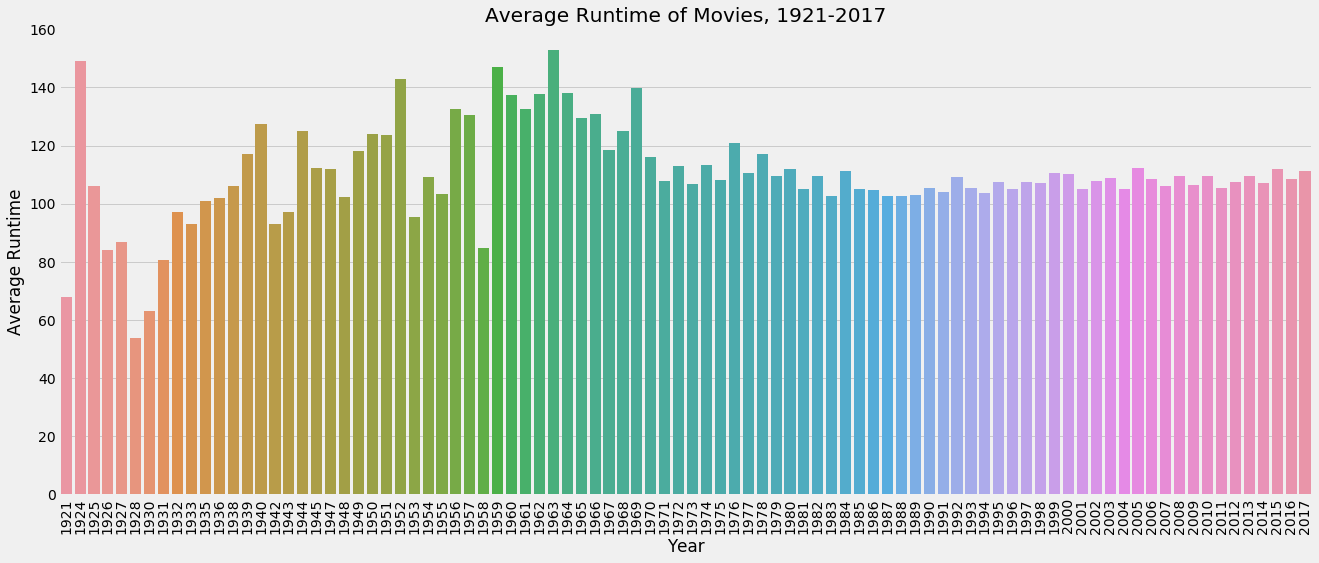

In [16]:
avg_runtime_by_year = train.groupby('release_year')['runtime'].mean()
avg_runtime_by_year_plot = sns.barplot(x=avg_runtime_by_year.index, y =avg_runtime_by_year.values)
avg_runtime_by_year_plot.set_xticklabels(labels=avg_runtime_by_year.index, rotation=90)
avg_runtime_by_year_plot.set(xlabel='Year', ylabel='Average Runtime', title='Average Runtime of Movies, 1921-2017')
plt.show()

**There no clear trend for the length of movies.**

### Revenue by Month / Number of Movies Released by Month: (Release_Date)

[Text(0,0.5,'Average Revenue'),
 Text(0.5,0,'Month'),
 Text(0.5,1,'Average Revenues by Month, 1921-2017')]

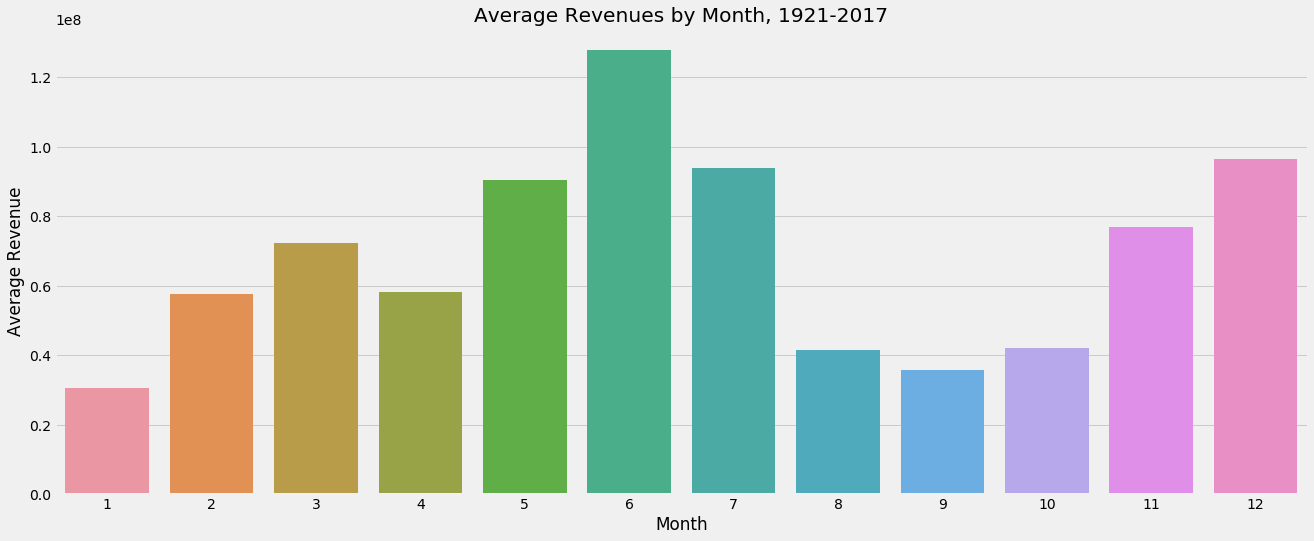

In [17]:
avg_rev_by_month = train.groupby('release_month')['revenue'].mean()
avg_rev_by_month_plot = sns.barplot(x= avg_rev_by_month.index, y=avg_rev_by_month.values)
avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month, 1921-2017')

#### By observing the average monthly revenues through 1921 to 2017, a trend can be found that average revenues were lowest between Jan to Feb and again Aug to Sept.

In [ ]:
df = train[train['release_year'] > 2010]
avg_rev_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['revenue'].mean()
avg_rev_by_year_and_month_plot = sns.lineplot(data=avg_rev_by_year_and_month, x='release_month', y='revenue', hue = 'release_year', legend = 'full', palette='Set1')
avg_rev_by_year_and_month_plot.set(xlabel='Month', ylabel='Revenue', title='Monthly Average Revenues by Month, 2011-2017')
avg_rev_by_year_and_month_plot

**The same trend can be found when taking a closer look at monthly average revenues between 2010-2017.**

In [ ]:
num_of_movies_by_year_and_month = df.groupby(['release_year', 'release_month'], as_index=False)['imdb_id'].count()
num_of_movies_by_year_and_month_plot = sns.lineplot(data=num_of_movies_by_year_and_month, x='release_month', y='imdb_id', hue='release_year', legend='full', palette='Set1')
num_of_movies_by_year_and_month_plot.set(xlabel='Month', ylabel='Number of Movies released', title='Monthly Number of Released Movies, 2011-2017')
plt.show()

**By contrast, August to October see the most number of movies released when we look at the data from 2011-2017. (The same pattern persists for previous years also.)**


**A closer look at this trend is provided below, where we can compare the average revenues with number of releases each year:**

In [ ]:
def display_monthly_avg_rev_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month')['revenue'].mean()
    avg_rev_by_month_plot = sns.barplot(x=table.index, y=table.values)
    avg_rev_by_month_plot.set(xlabel='Month', ylabel='Average Revenue', title='Average Revenues by Month in '+ str(year))
    plt.show()
    
def display_monthly_num_of_movies_by_year(year):
    df = train[train['release_year'] == year]
    table = df.groupby('release_month', as_index=False)['imdb_id'].count()
    plot = sns.barplot(data=table, x='release_month', y='imdb_id')
    plot.set(xlabel='Month', ylabel='Number of Movies released', title='Number of Released Movies by Month in ' + str(year))
    plt.show()

def compare_num_with_rev_by_year(year):
    display_monthly_avg_rev_by_year(year)
    display_monthly_num_of_movies_by_year(year)


In [ ]:
compare_num_with_rev_by_year(2010)

A trend can be identified by comparing monthly number of movies released and monthly average revenues: they seem to be inversely correlated.

### Genre:

In [11]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

combined['genres'] = combined['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = combined.genres.str.get_dummies(sep=',')
combined = pd.concat([combined, genres], axis=1, sort=False)

In [12]:
train = combined[combined['is_train'] == 1].drop(['is_train'], axis=1)
test = combined[combined['is_train'] == 0].drop(['is_train', 'revenue'], axis=1)

**Compare the revenues between different genres throughout the years:**

In [ ]:
# calculate the total revenue and avg revenue for each genre in each year, in order to plot the animation plot:
# colnames: 'genre', 'year', 'avg_rev', 'total_rev', 'num_of_productions'
def get_genre_animation_df(dataset, years, genres):
    result =[]
    for year in years:
        df_by_year = dataset[dataset['release_year'] == year]
        for genre in genres:
            df_by_year_and_genre = df_by_year[df_by_year[genre] == 1]
            result.append([year, genre, df_by_year_and_genre['revenue'].mean(), 
                           df_by_year_and_genre['revenue'].sum(),df_by_year_and_genre.shape[0]])
            
    return result
         

In [ ]:
df = get_genre_animation_df(train, np.arange(1912,2018), genres.columns)
genre_animation_plot_df = pd.DataFrame(df, columns=['year', 'genre', 'avg_rev', 'total_rev', 'num_of_productions'])
genre_animation_plot_df = genre_animation_plot_df.fillna(0)
px.scatter(genre_animation_plot_df, x='avg_rev', y = 'total_rev', animation_frame = 'year',
          size = 'num_of_productions', color='genre', hover_name = 'genre',
          size_max=55, range_x = [-3e+8, 7e+08], range_y = [-3e+8, 9e+09])

In [ ]:
# Here we count movies multiple times if it has multiple genres
def get_unpacked_df_by_genre(dataset, genres):
    result = pd.DataFrame(columns=['title', 'genre', 'revenue','budget'])
    for genre in genres:
        genre_df = dataset[dataset[genre] == 1][['title', 'genres', 'revenue', 'budget']]
        genre_df['genres'] = genre
        genre_df.columns = ['title', 'genre', 'revenue', 'budget']
        result = pd.concat([result, genre_df], ignore_index=True)
    return result

df_by_genre = get_unpacked_df_by_genre(train, genres.columns)
px.box(df_by_genre, x= 'genre', y='revenue')

    

**As it can be seen from both the animation plot and boxplot, genres like Advenure/Animation/Action/Fantasy are likely to make more revenues, as expected.**

### Language:

#### Exploring language related variables

In [ ]:
#count
[train['original_language'].count(), train['spoken_languages'].count()]

In [ ]:
#NA count
(train['spoken_languages'].isna()).sum()

In [ ]:
#NaN columns of spoken_languages variable

#train['spoken_languages'].index('')
#print(train[train["spoken_languages"].isnull()][null_columns])
#NaN in train['spoken_languages']
train[train['spoken_languages'].isnull()]

In [ ]:
train['original_language'].head(15)

In [ ]:
train['spoken_languages'].head(15)

In [ ]:
#engineering spoken_languages column

#train['spoken_languages'].map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str,x)))
train['spoken_languages_two'] = train['spoken_languages'].map(lambda x: sorted([d['iso_639_1'] for d in get_dictionary(x)]))

In [ ]:
train['spoken_languages_two'].head(15)
train['spoken_languages_two'][3]
train['spoken_languages_two'][3][1]
train['spoken_languages_two'][150] #empty for original NaN

In [ ]:
train['spoken_languages_two'].isna().sum() #0
train['spoken_languages_two'].count() #3000

In [ ]:
train['original_language'][1] in train['spoken_languages_two'][1]
train['orig_in_spok_language'] = np.array(0)

#for i in train['original_language']:
 #   if (train['original_language'][i] in train['spoken_languages_two'][i] == TRUE):
  #      train['orig_in_spok_language'] = 1
   # else:
    #    train['orig_in_spok_language'] = 0

In [ ]:
index_list = []
for idx, row in train.iterrows():
    index_list.append(row['original_language'] in row['spoken_languages_two'])

index_list #True means the original language is contained in spoken languages
len(index_list)

In [ ]:
not_index_list = [not i for i in index_list]
not_index_list #reverse of index_list

train[not_index_list] #those whose original language is not a part of spoken languages
len(train[not_index_list].index)

In [ ]:
#index_list.index(False) #92: first row of the one that is false
sum(not_index_list)
index_list.count(False)

#### Distribution of movies according to original languages usage

In [ ]:
train['original_language'].unique()

In [ ]:
len(train['original_language'].unique())

In [ ]:
#plt.figure(figsize=(20,15))
#sns.countplot(train['original_language'].sort_values())#alphabetical order
#plt.ylabel('Number of Movies')
#plt.xlabel('Original Languages')
#plt.title("Counts for Original Languages of Movies (alphabetical order)",fontsize=20)
#plt.show()

In [ ]:
train.groupby(['original_language']).original_language.count().nlargest(36) #top 5 of all 36 languages

In [ ]:
#plt.figure(figsize=(20,15))
#train_OrigLang=train.groupby(['original_language']).original_language.count().nlargest(36)
#bar1=sns.barplot(train_OrigLang.index, train_OrigLang.values,alpha=0.8)

#plt.ylabel('Number of Movies')
#plt.xlabel('Original Languages')
#plt.title("Counts for Original Languages of Movies (descending order)",fontsize=20)
#plt.show()

In [ ]:
#y_pos = train['original_language']
#performance = train['revenue']

#plt.bar(y_pos, performance, align='center', alpha=0.5)
#plt.ylabel('Revenue')
#plt.title('Revenue of Movies with Different Original Languages')

#plt.show()

In [ ]:
train_RevByOrigLang=train.groupby(['original_language']).revenue.mean()
train_RevByOrigLang.nlargest(5) 

In [ ]:
train_RevByOrigLang=train.groupby(['original_language']).revenue.mean()
train_RevByOrigLang=train_RevByOrigLang.nlargest(36) #descending order, 36 original languages in total

#plt.figure(figsize=(13,5))
bar2=sns.barplot(train_RevByOrigLang.index, train_RevByOrigLang.values,alpha=0.8)
#bar2.set_ylim([0,100000000])
plt.ylabel("Mean Revenue")
plt.title("Mean Revenue of Movies with Different Original Languages")

### Cast/Crew

In [ ]:
# TODO: 1. scrape data online to fill in the nan
crew_cast_dataset = train[pd.notnull(train['cast']) & pd.notnull(train['crew'])]
crew_cast_dataset['cast'] = crew_cast_dataset['cast'].apply(literal_eval)
crew_cast_dataset['crew'] = crew_cast_dataset['crew'].apply(literal_eval)

In [ ]:
# contruct two features:
# economic_idx: total revenues of the top five cast/crew members, ranked by the average revenue of their most recent five films
# artistic_idx: the number of crew/cast members who are involved in the production of a film nominated for Academy Award
def was_involved(dict_list, name):
    """
    Check if the name got involved in the production of this film.
    """
    was_involved = False
    for name_dict in dict_list:
        if name_dict['name'] == name:
            was_involved = True
    return was_involved
    
    
def get_recent_five_avg_rev(name, cast_or_crew, year, month):
    """
    Get a list of the revenues of 5 most recent films by name.
    The list length can be shorter than 5.
    """
    # filter the dataset by time to find the most recent five films
    target_df = crew_cast_dataset[crew_cast_dataset['release_year'] <= year]
    # drop the rows with year equal to target year but month larger than target month
    drop_idx = target_df[(target_df['release_year'] == year) & (target_df['release_month'] >= month)].index
    target_df = target_df.drop(drop_idx)
    
    
    # subset the target_df to get the rows that contain the cast/crew
    if cast_or_crew == 'cast':
        target_df = target_df[target_df.apply(lambda row: was_involved(row['cast'], name), axis=1)]
    
    if cast_or_crew == 'crew':
        target_df = target_df[target_df.apply(lambda row: was_involved(row['crew'], name), axis=1)]
    
    # sort the dataframe by release date:
    target_df.sort_values(by=['release_year', 'release_month', 'release_day'], ascending = False)
    
    avg_rev = target_df['revenue'][:5].mean()
    
    if math.isnan(avg_rev):
        return 0
    else:
        return avg_rev
    
    

def get_economic_idx(row):
    cast_rev_list = []
    crew_rev_list = []
    for cast_dict in row['cast']:
        print("=============================\nName: " + str(cast_dict['name']) + str(row['release_year']) + str(row['release_month']))
        rev = get_recent_five_avg_rev(cast_dict['name'], 'cast', row['release_year'], row['release_month'])
        print("Revenue: " + str(rev))
        cast_rev_list.append(rev)              
    for crew_dict in row['crew']:
        crew_rev_list.append(get_recent_five_avg_rev(crew_dict['name'], 'crew', row['release_year'], row['release_month']))
        
    return (sum(sorted(cast_rev_list, reverse=False)[:5]) + sum(sorted(crew_rev_list, reverse=False)[:5]))

In [ ]:
# Get economic_idx, the computation is really expensive so we save the dataset and reuse the results here:
# ['economic_idx'] = crew_cast_dataset.apply(lambda row: get_economic_idx(row), axis=1)
# crew_cast_dataset.to_csv('../data/crew_cast_dataset.csv')
crew_cast_dataset = pd.read_csv('../data/crew_cast_dataset.csv')
crew_cast_dataset['cast'] = crew_cast_dataset['cast'].apply(literal_eval)
crew_cast_dataset['crew'] = crew_cast_dataset['crew'].apply(literal_eval)
crew_cast_dataset['economic_idx'].corr(crew_cast_dataset['revenue'])

In [ ]:
# construct artistic_idx:
oscar_nominations = pd.read_csv('../data/oscar_nominations.csv')
oscar_nominations.head()

In [ ]:
def get_oscar_nominee_count(dict_list):
    nominee_count = 0
    for name_dict in dict_list:
        print(name_dict['name'])
        if name_dict['name'] in oscar_nominations['Name']:
            nominee_count = nominee_count + 1
    return nominee_count

In [ ]:
train['was_nominated_for_oscar'] = train['title'].isin(oscar_nominations.Film)
px.box(train, x='was_nominated_for_oscar', y='revenue')

In [ ]:
# filter the dataset the get the films that were nominated for oscar
oscar_films = train[train['was_nominated_for_oscar'] == True]


# def get_num_of_nominated_films(target_df, name):
#     """
#     Get the number of times a name was involved in the production of an oscar-nominated film
#     """
#     for idx, row in target_df
    
    
#     count = sum(target_df['crew'].apply(lambda x: was_involved(name, )))

def get_artistic_idx(row):
    count = 0
    # filter the dataset to be earlier than the year and month:
    target_df = oscar_films[oscar_films['release_year'] <= row['release_year']]
    # print(target_df.index)
    drop_idx = oscar_films[(oscar_films['release_year'] == row['release_year']) & (oscar_films['release_month'] >= row['release_month'])].index
    # print(oscar_films[(oscar_films['release_year'] == row['release_year']) & (oscar_films['release_month'] >= row['release_month'])])
    target_df = target_df.drop(drop_idx)
    
    for name_dict in row['cast']:
        target_name = name_dict['name']
        target_name_count = 0
        for idx, row in target_df.iterrows():
            # count the number of times this name appears in the cast column:
            for oscar_name_dict in row['cast']:
                if target_name == oscar_name_dict['name']:
                    target_name_count = target_name_count + 1
            # count the number of times this name appears in the crew column:
            for oscar_name_dict in row['crew']:
                if target_name == oscar_name_dict['name']:
                    target_name_count = target_name_count + 1
        count = count + target_name_count
        
    for name_dict in row['crew']:
        target_name = name_dict['name']
        target_name_count = 0
        for idx, row in target_df.iterrows():
            # count the number of times this name appears in the cast column:
            for oscar_name_dict in row['cast']:
                if target_name == oscar_name_dict['name']:
                    target_name_count = target_name_count + 1
            # count the number of times this name appears in the crew column:
            for oscar_name_dict in row['crew']:
                if target_name == oscar_name_dict['name']:
                    target_name_count = target_name_count + 1
        count = count + target_name_count
        
    return count

In [ ]:
train = train[pd.notnull(train['cast']) & pd.notnull(train['crew'])]
# train['cast'] = train['cast'].apply(literal_eval)
# train['crew'] = train['crew'].apply(literal_eval)
# train['artistic_idx'] = train.apply(lambda row: get_artistic_idx(row), axis = 1)

In [ ]:
fig = px.scatter(train, x='artistic_idx', y = 'revenue')
fig.update_layout(yaxis_type="log")


**It can be seen that movies nominated for Oscar tend to generate more revenues.**

## Feature Engineering

In [13]:
combined.columns

Index([u'id', u'belongs_to_collection', u'budget', u'genres', u'homepage',
       u'imdb_id', u'original_language', u'original_title', u'overview',
       u'popularity', u'poster_path', u'production_companies',
       u'production_countries', u'release_date', u'runtime',
       u'spoken_languages', u'status', u'tagline', u'title', u'Keywords',
       u'cast', u'crew', u'revenue', u'is_train', u'release_month',
       u'release_day', u'release_year', u'release_dayofweek',
       u'release_quarter', u'Action', u'Adventure', u'Animation', u'Comedy',
       u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign',
       u'History', u'Horror', u'Music', u'Mystery', u'Romance',
       u'Science Fiction', u'TV Movie', u'Thriller', u'War', u'Western'],
      dtype='object')

In [14]:
def engineer_features(train_df):
    # TODO: add collection_idx
    # TODO: how to deal with budget?
    # TODO: add production_company_idx
    # TODO: spoken_language?
    # TODO: Keywords?
    
    # original_language:
    original_language_dummies = pd.get_dummies(train_df['original_language'])
    train_df = pd.concat([train_df, original_language_dummies], axis=1, sort=False)
    
    train_df['num_of_production_companies'] = train_df['production_companies'].apply(lambda x: len(literal_eval(x)) if pd.notnull(x) else x)
    train_df['num_of_production_countries'] = train_df['production_countries'].apply(lambda x: len(literal_eval(x)) if pd.notnull(x) else x)
    train_df['num_of_spoken_languages'] = train_df['spoken_languages'].apply(lambda x: len(literal_eval(x)) if pd.notnull(x) else x)
    
    
    # TODO: take log of the revenue
    
    train_df = train_df.drop(['id', 'status', 'homepage', 'original_title', 'overview', 'poster_path', 'tagline', 'cast', 'crew', 
                              'belongs_to_collection', 'genres', 'imdb_id', 'original_language', 
                              'production_companies', 
                             'production_countries', 'release_date', 'spoken_languages', 'title', 'Keywords'], axis=1)
    
    return train_df
    
    
    
    

In [15]:
combined = engineer_features(combined)

In [16]:
train = combined[combined['is_train'] == 1].drop(['is_train'], axis=1)
test = combined[combined['is_train'] == 0].drop(['is_train', 'revenue'], axis=1)


In [17]:
train['revenue'] = np.log1p(train['revenue'])

In [18]:
y = train['revenue'].values
train = train.drop(columns=['revenue'])

In [19]:
train.columns

Index([u'budget', u'popularity', u'runtime', u'release_month', u'release_day',
       u'release_year', u'release_dayofweek', u'release_quarter', u'Action',
       u'Adventure', u'Animation', u'Comedy', u'Crime', u'Documentary',
       u'Drama', u'Family', u'Fantasy', u'Foreign', u'History', u'Horror',
       u'Music', u'Mystery', u'Romance', u'Science Fiction', u'TV Movie',
       u'Thriller', u'War', u'Western', u'af', u'ar', u'bm', u'bn', u'ca',
       u'cn', u'cs', u'da', u'de', u'el', u'en', u'es', u'fa', u'fi', u'fr',
       u'he', u'hi', u'hu', u'is', u'it', u'ja', u'ka', u'kn', u'ko', u'ml',
       u'mr', u'nb', u'nl', u'no', u'pl', u'pt', u'ro', u'ru', u'sr', u'sv',
       u'ta', u'te', u'th', u'tr', u'ur', u'vi', u'xx', u'zh',
       u'num_of_production_companies', u'num_of_production_countries',
       u'num_of_spoken_languages'],
      dtype='object')

## Modeling

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error

from xgboost import XGBClassifier
# import lightgbm as lgb
# from catboost import CatBoostRegressor

random_seed = 2019
k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train))
np.random.seed(random_seed)

In [21]:
import xgboost as xgb

def xgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    params = {'objective': 'reg:linear', 
              'eta': 0.01, 
              'max_depth': 6, 
              'subsample': 0.6, 
              'colsample_bytree': 0.7,  
              'eval_metric': 'rmse', 
              'seed': random_seed, 
              'silent': True,
    }
    
    record = dict()
    model = xgb.train(params
                      , xgb.DMatrix(trn_x, trn_y)
                      , 100000
                      , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
                      , verbose_eval=verbose
                      , early_stopping_rounds=500
                      , callbacks = [xgb.callback.record_evaluation(record)])
    best_idx = np.argmin(np.array(record['valid']['rmse']))

    val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)

    return {'val':val_pred, 'test':test_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

In [22]:
import lightgbm as lgb

def lgb_model(trn_x, trn_y, val_x, val_y, test, verbose) :

    params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         #'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         #'subsample':.8, 
          #'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}

    record = dict()
    model = lgb.train(params
                      , lgb.Dataset(trn_x, trn_y)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(val_x, val_y)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                      , callbacks = [lgb.record_evaluation(record)]
                     )
    best_idx = np.argmin(np.array(record['valid_0']['rmse']))

    val_pred = model.predict(val_x, num_iteration = model.best_iteration)
    test_pred = model.predict(test, num_iteration = model.best_iteration)
    
    return {'val':val_pred, 'test':test_pred, 'error':record['valid_0']['rmse'][best_idx], 'importance':model.feature_importance('gain')}

/anaconda3/envs/py36/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [24]:
from catboost import CatBoostRegressor

def cat_model(trn_x, trn_y, val_x, val_y, test, verbose) :
    
    model = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
    model.fit(trn_x, trn_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=False)
    
    val_pred = model.predict(val_x)
    test_pred = model.predict(test)
    
    return {'val':val_pred, 
            'test':test_pred, 
            'error':model.get_best_score()['validation']['RMSE']}

In [25]:
result_dict = dict()
val_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])
final_err = 0
verbose = False

for i, (trn, val) in enumerate(fold) :
    print(i+1, "fold.    RMSE")
    
    trn_x = train.loc[trn, :]
    trn_y = y[trn]
    val_x = train.loc[val, :]
    val_y = y[val]
    
    fold_val_pred = []
    fold_test_pred = []
    fold_err = []
    
    #""" xgboost
    start = datetime.now()
    result = xgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.2)
    fold_test_pred.append(result['test']*0.2)
    fold_err.append(result['error'])
    print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    #""" lightgbm
    start = datetime.now()
    result = lgb_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("lgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    #""" catboost model
    start = datetime.now()
    result = cat_model(trn_x, trn_y, val_x, val_y, test, verbose)
    fold_val_pred.append(result['val']*0.4)
    fold_test_pred.append(result['test']*0.4)
    fold_err.append(result['error'])
    print("cat model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')
    #"""
    
    # mix result of multiple models
    val_pred[val] += np.mean(np.array(fold_val_pred), axis = 0)
    #print(fold_test_pred)
    #print(fold_test_pred.shape)
    #print(fold_test_pred.columns)
    test_pred += np.mean(np.array(fold_test_pred), axis = 0) / k
    final_err += (sum(fold_err) / len(fold_err)) / k
    
    print("---------------------------")
    print("avg   err.", "{0:.5f}".format(sum(fold_err) / len(fold_err)))
    print("blend err.", "{0:.5f}".format(np.sqrt(np.mean((np.mean(np.array(fold_val_pred), axis = 0) - val_y)**2))))
    
    print('')
    
print("fianl avg   err.", final_err)
print("fianl blend err.", np.sqrt(np.mean((val_pred - y)**2)))

(1, 'fold.    RMSE')
('xgb model.', '2.20866', '(0m)')
('lgb model.', '2.22479', '(0m)')
('cat model.', '2.18091', '(1m)')
---------------------------
('avg   err.', '2.20479')
('blend err.', '10.77042')

(2, 'fold.    RMSE')
('xgb model.', '1.85171', '(0m)')
('lgb model.', '1.81161', '(0m)')
('cat model.', '1.87281', '(0m)')
---------------------------
('avg   err.', '1.84538')
('blend err.', '11.05326')

(3, 'fold.    RMSE')
('xgb model.', '2.24267', '(0m)')
('lgb model.', '2.26193', '(0m)')
('cat model.', '2.24461', '(0m)')
---------------------------
('avg   err.', '2.24974')
('blend err.', '10.92374')

(4, 'fold.    RMSE')
('xgb model.', '1.89213', '(0m)')
('lgb model.', '1.94246', '(0m)')
('cat model.', '1.97466', '(0m)')
---------------------------
('avg   err.', '1.93642')
('blend err.', '11.06721')

(5, 'fold.    RMSE')
('xgb model.', '2.10884', '(0m)')
('lgb model.', '2.04346', '(0m)')
('cat model.', '2.09765', '(0m)')
---------------------------
('avg   err.', '2.08332')
('b

In [27]:
sub = pd.read_csv('../data/sample_submission.csv')
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']
df_sub['revenue'] = np.expm1(test_pred*3)
#print(df_sub['revenue'])
df_sub.to_csv("submission.csv", index=False)

### Summary for release_year and release_month:
1. Revenues are generally low during Jan to Feb, also Aug to Sept. There are called Dump Months, more information can be found at:
    - https://www.wikiwand.com/en/Dump_months
    - https://web.archive.org/web/20151012234912/http://www.theatlantic.com/entertainment/archive/2012/01/january-dumping-ground-for-terrible-movies-like-contraband/251326/
    - https://web.archive.org/web/20150922062108/http://www.avclub.com/article/hollywoods-trash-our-treasure-17-salvageable-flops-91570
    

In [ ]:
train['spoken_languages'].head(15)

In [ ]:
country = {'Country': 'China', 'Capital': 'Beijing'}